In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns = iris.feature_names)
iris_df['label'] = iris.target

#取出前 100 条经录， 并且将其划分为训练集与标签两部分
'''
iloc，即index locate 用index索引进行定位，所以参数是整型，如：df.iloc[10:20, 3:5]
loc，则可以使用column名和index名进行定位，如：df.loc[‘image1’:‘image10’, ‘age’:‘score’]
'''
data = np.array(iris_df.iloc[:100, [0, 1, -1]])
X, Y = data[:, :-1],data[:, -1]
print(data.shape)


(100, 3)


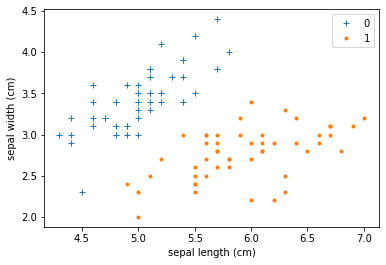

In [3]:
# 绘制样本点
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()

In [4]:
# 保存数据点
np.savez_compressed('iris.npz', data = data, X = X, Y = Y )

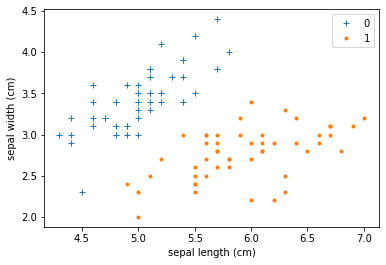

In [5]:
# 测试保存的数据集
iris_npz = np.load('iris.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']

# 绘制样本点
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100, 1], '.', label='1')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()

In [6]:
'''
节点类
'''
class KDNode:
    
    # 保存数据、划分的维度、左子树、右子树
    def __init__(self, sample, feature_index, left, right):
        self.sample = sample
        self.feature_index = feature_index
        self.left = left
        self.right = right

In [7]:
'''
KD树类：

'''
class KDTree:
    def __init__(self, dataSet):
        self.n_feature = dataSet.shape[1] - 1
        self.root = self.CreateKDTree(dataSet, 0)
    
    # 生成KD树
    def CreateKDTree(self, dataSet, feature_index):
        if len(dataSet) == 0:
            return None;
        dataSet = sorted(dataSet, key = lambda x : x[feature_index])
        split_pos = len(dataSet) // 2
        return KDNode(dataSet[split_pos], feature_index, \
                          self.CreateKDTree(dataSet[:split_pos], (feature_index + 1)\
                                            % self.n_feature), \
                          self.CreateKDTree(dataSet[split_pos+1:], (feature_index + 1) \
                                            % self.n_feature))
    
    # 寻找最近的节点
    def _FindNearest(self, kdnode, source, target, mindist):
        if kdnode == None:
            return None, float('inf')
        
        pivot = kdnode.sample
        # 判断是优先进入左子树遍历，还是优先进入右子树遍历
        if source[kdnode.feature_index] <= pivot[kdnode.feature_index]:
            forward = kdnode.left
            backward = kdnode.right
        else:
            forward = kdnode.right
            backward = kdnode.left
            
        # 判断更有可能的子树的最小距离
        forward_result = self._FindNearest(forward,  source, target, mindist)
        if forward_result[1] < mindist:
            target = forward_result[0]
            mindist = forward_result[1]
           
        # 判断与根节点的距离， 如果这个距离大于最小距离，则不需要遍历之后的子树
        # np.linalg.normal计算向量的范数， ord 指定为第几范数\
        to_pivot = np.linalg.norm(source[:-1] - pivot[:-1], ord=2)
        if mindist < to_pivot:
            return target, mindist
        
        # 更新最近点
        target = pivot
        mindist = to_pivot
        
        # 进入剩下的子树的， 寻找最小距离
        backward_result = self._FindNearest(backward, source, target, mindist)
        if backward_result[1] < mindist:
            target = backward_result[0]
            mindist = backward_result[1]
        return target, mindist
    
    def Nearest(self, source):
        result = self._FindNearest(kdnode=self.root, source=source, target=None, mindist=float('inf'))
        return result[0]

In [8]:
# 最后一列是标签
example_data = np.array([[2, 3, 0],[5, 4, 0],[9, 6, 0],[4, 7, 1],[8, 1, 1],[7, 2, 1]])
example_kdtree = KDTree(example_data)

In [9]:
# 先根序列打印KDtree
def print_kDTree(root):
    if root == None:
        return
    print(root.sample)
    print_kDTree(root.left)
    print_kDTree(root.right)
    
print_kDTree(example_kdtree.root)

[7 2 1]
[5 4 0]
[2 3 0]
[4 7 1]
[9 6 0]
[8 1 1]


In [10]:
source_t = np.array([2, 16, 0])
print('Nearst', example_kdtree.Nearest(source_t))
print('Nearst:', example_data[np.argmin([np.linalg.norm(item[:-1]-source_t[:-1], ord = 2) for item in example_data])])

Nearst [4 7 1]
Nearst: [4 7 1]


In [11]:
np.linalg.norm(np.array([2, 16, 0])[:-1] - np.array([2, 3, 0])[:-1], ord=2)
np.linalg.norm(np.array([2, 16, 0])[:-1] - np.array([4, 7, 1])[:-1], ord=2)

9.219544457292887

In [12]:
import time
from random import random

K = 66 # 样本点的维数
N = 40000 # 样本点的个数
random_data = np.array([[random() for k in range(K)] for n in range(N)])

t0 = time.process_time()
random_kdtree = KDTree(random_data)
t1 = time.process_time()
print("KDTree createing time", t1 - t0, 's')

rand_scource = [random() for k in range(K)]
t2 = time.process_time()
print("Nearest : ", random_kdtree.Nearest(rand_scource))
t3 = time.process_time()
print("KDTree searing tiem ", t3 - t2, 's')

t4 = time.process_time()
print("Nearest :", random_data[np.argmin( \
    np.linalg.norm(item[:-1]-source[:-1], ord = 2) for item in random_data)])
t5 = time.process_time()
print("One-By-One searching time :", t5-t4, 's')

KDTree createing time 0.5 s
Nearest :  [0.29047391 0.6638572  0.57721644 0.39563015 0.64253242 0.94631053
 0.73193189 0.56355104 0.40949968 0.33502106 0.77695766 0.49280457
 0.30451521 0.53951686 0.95601581 0.80421122 0.62836382 0.45924978
 0.15737091 0.69482697 0.68641266 0.76088251 0.21960332 0.87393746
 0.4802126  0.65416896 0.41983908 0.98564349 0.68796552 0.57552179
 0.64754779 0.19282205 0.84534712 0.52676164 0.13140416 0.5079644
 0.5350532  0.41443447 0.61069415 0.49797337 0.41161882 0.17341144
 0.83644747 0.48580093 0.08643935 0.64157944 0.8595093  0.96462858
 0.70968817 0.39908044 0.05401113 0.26826076 0.34851127 0.45946726
 0.73858614 0.87220188 0.01919121 0.05593041 0.29861437 0.66098608
 0.09623832 0.52016064 0.9721814  0.49587948 0.69242901 0.1476642 ]
KDTree searing tiem  0.0 s
Nearest : [0.36863183 0.82235621 0.08762357 0.75933967 0.05506978 0.15958263
 0.03417848 0.75163102 0.63998574 0.92625506 0.09565424 0.32929397
 0.81878126 0.91706951 0.25886903 0.06323129 0.864219

In [13]:
iris_kdtree = KDTree(data)
iris_source =  np.array([5, 4, 0])
print('Nearest', iris_kdtree.Nearest(iris_source))
print('Nearest', data[np.argmin(np.linalg.norm(item[:-1] - iris_source[:-1], ord = 2) for item in data)])

Nearest [5.1 3.8 0. ]
Nearest [5.1 3.5 0. ]


[5.1 3.3 0. ]
[5.1 3.5 0. ]


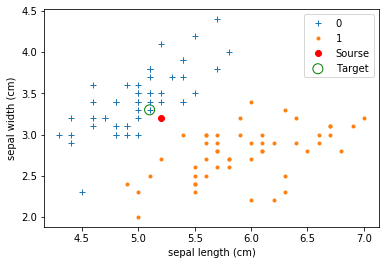

In [14]:
# 作图可视化
iris_source_2 = np.array([5.2, 3.2, 0])
target_2 = iris_kdtree.Nearest(iris_source_2)
print(target_2)
target_3 = data[np.argmin(np.linalg.norm(item[:-1] - iris_source[:-1], ord = 2) for item in data)]
print(target_3)
plt.plot(data[:50, 0], data[:50, 1], '+', label='0')
plt.plot(data[50:100, 0], data[50:100,1], '.', label='1')
plt.plot(iris_source_2[0], iris_source_2[1], 'ro', label='Sourse')
# scatter 绘制散点图
plt.scatter(target_2[0], target_2[1], color='', marker='o', edgecolors='g', s=100, label='Target')
plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
plt.legend()

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# 因为是随机划分，所以和pdf不一样
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [16]:
clf = KNeighborsClassifier(algorithm='auto', leaf_size=30,
                           metric='minkowski',metric_params=None,
                           n_jobs=1, n_neighbors=5, p=2,weights='uniform')
clf.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=5, p=2,
                     weights='uniform')

In [17]:
clf.score(X_test, Y_test)

1.0